In [92]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset, WFLWDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cuda


In [94]:
wflw_data_loc = '/home/data/wflw/'

train_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)
val_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)
test_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

In [95]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [96]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_pretrain_1/checkpoint_9"

model.pt  optimizer.pt  results.csv


In [97]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_pretrain_1/checkpoint_9/results.csv"
model_results = pd.read_csv(model_path)

In [154]:
num_landmarks = 98
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

(2500, 98, 2) (2500, 98, 2)


In [99]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
        
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=10, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


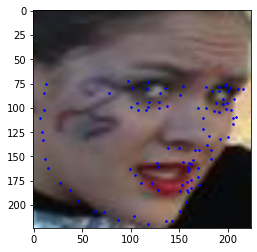

Truth


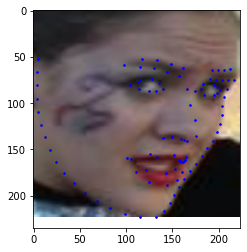

tensor([[0, 0, 0, 1, 0, 0]], dtype=torch.int32)


In [100]:
img_num = 1928

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()
print(sample['attributes'])

# Only run once to generate predictions

In [101]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [102]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_nopretrain_1/"

checkpoint_0/   checkpoint_15/  checkpoint_21/  checkpoint_6/
checkpoint_1/   checkpoint_16/  checkpoint_22/  checkpoint_7/
checkpoint_10/  checkpoint_17/  checkpoint_23/  checkpoint_8/
checkpoint_11/  checkpoint_18/  checkpoint_24/  checkpoint_9/
checkpoint_12/  checkpoint_19/  checkpoint_3/   checkpoint_batch_0/
checkpoint_13/  checkpoint_2/   checkpoint_4/
checkpoint_14/  checkpoint_20/  checkpoint_5/


In [103]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_nopretrain_1/checkpoint_13/model.pt"
model = torch.load(model_path).to(device)

In [104]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=98*2, device=device)

100%|██████████| 625/625 [01:03<00:00,  9.83it/s]


In [105]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Evaluation

In [243]:
# load data and predictions
x = pd.read_csv(wflw_data_loc+'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt').values
y_hat = y_pred[:-1, :, :]
y_new = y[:-1, :, :]

num_samples = len(x)
total_size = len(x[0][0].split()[:-1])

x = [x[i][0].split()[:-1] for i in range(num_samples)]
x = np.asarray(x, dtype=np.float).reshape(num_samples, total_size)[:, -6:]

num_samples, num_features = x.shape

assert(y_hat.shape == y_new.shape)
print('Num_samples:', num_samples) 
print('Num_features:', num_features) 

Num_samples: 2499
Num_features: 6


In [169]:
# define d to be either interocular distance or bounding box diagonal length
d = np.array([1*2**0.5]*num_samples)

In [244]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
counts = np.sum(x, axis=0)
maj = np.where(counts > num_samples/2, 1, 0)
Z = [[i,maj[i]] for i in range(num_features)]

alpha = 0.2
beta = 1
# calculate_landmark = True

In [245]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m
d is the interocular distance
"""

def calc_nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    return np.square(np.linalg.norm(y_hat-y, axis=(1,2))) / d 

def calc_nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = np.square(y_hat-y) / d[:, np.newaxis, np.newaxis] 
    return np.mean(nme, axis=2)

def calc_total_nme(nme):
    # Output: average NME across all images
    return np.mean(nme, axis=0)

def create_ced(nme):
    # Output: plot of the CED
    x = np.sort(nme)
    y = np.arange(nme.shape[0]) / float(nme.shape[0])
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def calc_auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    num_under_alpha = np.where(nme < alpha, 1, 0)
    return np.sum(num_under_alpha) / nme.shape[0]

def calc_fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-calc_auc(nme, alpha)

In [246]:
nme_images = calc_nme_images(y_hat, y_new, num_landmarks, d)
nme_landmark = calc_nme_landmark(y_hat, y_new, num_landmarks, d)
total_nme = calc_total_nme(nme_images)
total_nme_landmark = calc_total_nme(nme_landmark)
fr = calc_fr(nme_images, alpha)

print('Average Normalized Mean Error:', total_nme, '\n')
print('Average Normalized Mean Error Per Landmark')
for i in range(num_landmarks):
    print(f'Landmark {i}: {total_nme_landmark[i]}')
print('\n')
print(f'Failure Rate Threshold at {alpha}: {fr}')

Average Normalized Mean Error: 0.2247203402510697 

Average Normalized Mean Error Per Landmark
Landmark 0: 0.002477325787422398
Landmark 1: 0.0022707805196307317
Landmark 2: 0.0018267177388346066
Landmark 3: 0.0015625784062551753
Landmark 4: 0.0014488469100358966
Landmark 5: 0.0015509205353103584
Landmark 6: 0.0012844036485890095
Landmark 7: 0.001322524693849268
Landmark 8: 0.0012418705182729117
Landmark 9: 0.0011207941257076355
Landmark 10: 0.0011300777429205217
Landmark 11: 0.0011947347408556006
Landmark 12: 0.0010727098401425246
Landmark 13: 0.0011011693320028071
Landmark 14: 0.0012487009752605957
Landmark 15: 0.0011843571786616907
Landmark 16: 0.0012722384656936418
Landmark 17: 0.0012269036913475067
Landmark 18: 0.0011173610260312799
Landmark 19: 0.001136306770195718
Landmark 20: 0.0011313193781847823
Landmark 21: 0.0011116363087562541
Landmark 22: 0.0011461173729755481
Landmark 23: 0.0014329628722367378
Landmark 24: 0.0012527665504380294
Landmark 25: 0.0013470081463122531
Landmark

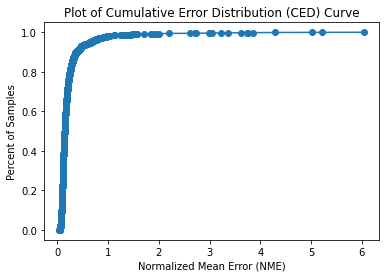

In [247]:
ced = create_ced(nme_images)

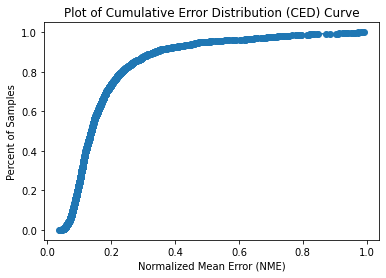

In [248]:
no_outliers = nme_images[np.where(nme_images<beta)]
ced = create_ced(no_outliers)

In [249]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def calc_mmd_err(majority, minority):
    difference = np.mean(majority, axis=0) - np.mean(minority, axis=0)
    return difference

def calc_mmd_fr(majority, minority, alpha):
    difference = calc_fr(majority, alpha) - calc_fr(minority, alpha)
    return difference

In [250]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


# if calculate_landmark:
#     mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[np.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[np.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = calc_mmd_err(majority, minority)
    mmd_fr[z] = calc_mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
# if calculate_landmark:
#     for z, maj in Z:
#         majority = nme_landmark[np.where(x[:, z] == maj)] # size # images in majority x m/2
#         minority = nme_landmark[np.where(x[:, z] != maj)] # size # images in minority x m/2
#         mmd_error_landmarks[z] = calc_mmd_err(majority, minority)

In [251]:
print('MMD in Error per Attribute')
for z, error in mmd_err.items():
    print(f'Attribute {z}: {error}')

MMD in Error per Attribute
Attribute 0: -0.13883534916897516
Attribute 1: 0.01728137963813664
Attribute 2: 0.024891603248500732
Attribute 3: 0.0012438310036854971
Attribute 4: -0.0463550217957171
Attribute 5: -0.02658068918183082


In [252]:
print('MMD in Failure Rate')
for z, error in mmd_fr.items():
    print(f'Attribute {z}: {error}')

MMD in Failure Rate
Attribute 0: -0.21131059093899185
Attribute 1: -0.01198676558469014
Attribute 2: 0.03815613420751596
Attribute 3: -0.014825619551272484
Attribute 4: -0.08102388468272959
Attribute 5: -0.029252030058507072
